**MACHINE LEARNING PROBLEM 1 TASK 2**

Gonçalo Ribeiro (100306) and Inês Nunes (100346)

NOTE: WE STILL NEED TO CHOOSE THE REGRESSOR AND THE PARAMETERS. WE SHOULD ALSO CHECK IF IN THE LAST CELLS THE VALUE ARE BEING COMPUTED CORRECTLY.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

In [2]:
u_train = np.load('u_train.npy')
output_train = np.load('output_train.npy')
u_test = np.load('u_test.npy')

In [3]:
def create_arx_regressor(y, u, n, m, d):
    N = len(y)
    p = max(n, d + m)
    X = []
    Y = []
    
    for k in range(p, N):
        # Past values of y(k), autoregressive part
        y_lags = [y[k - i] for i in range(1, n+1)]
        
        # Past values of u(k), exogenous input part
        u_lags = [u[k - d - j] for j in range(m + 1)]
        
        # Combine both sets of lags into a single row
        X.append(y_lags + u_lags)
        Y.append(y[k])
    return np.array(X), np.array(Y)

In [4]:
best_score = -np.inf
best_params = {}

# Define ranges for n, m, and d
n_range = range(1, 10)  # Autoregressive order
m_range = range(1, 10)  # Input lag order
d_range = range(1, 10)  # Delay

# Grid search over n, m, and d
for n in n_range:
    for m in m_range:
        for d in d_range:
            
            X_train, Y_train = create_arx_regressor(output_train, u_train, n, m, d)
            
            sample_size = X_train.shape[0]
            test_size = int(0.3*sample_size)
            
            X_train_split = X_train[:-test_size] 
            Y_train_split = Y_train[:-test_size] 
            
            X_val_split = X_train[-test_size:]  
            Y_val_split = Y_train[-test_size:] 
            
            lr = LinearRegression()
            lr.fit(X_train_split, Y_train_split)  # Fit the model with training data
            
            # Split data (or use cross-validation) to compute the R² score or AIC/BIC
            y_val = []
            aux = np.zeros(n)
            y_prev = list(Y_train_split[-n:][::-1])  # Initialize with last n values from the training set
            
            for k in range(test_size):
                # Extract lagged values of u (exogenous inputs) for prediction from X_val_split
                # Assuming that the first n columns in X_val_split are the y lags and the next m+1 columns are u lags
                u_lags = X_val_split[k, n:]  # Extract the lagged u values from the validation set
                
                # Predict using the model
                combined_input = y_prev + list(u_lags)[:m + 1]  # Combine y_prev and m lagged u values

                # Predict using the model
                y_pred = lr.predict([combined_input])  # The model expects a 2D array as input
                y_val.append(y_pred[0])

                # Update the previous values for the next prediction (autoregressive part)
                aux[:] = y_prev[:]  # Copy current values to auxiliary array
                y_prev[0] = y_pred[0]  # Replace the first element with the current prediction
                for i in range(1, n):
                    y_prev[i] = aux[i-1]  # Shift previous values to the right
            score = r2_score(Y_val_split, y_val)
            mse = mean_squared_error(Y_val_split, y_val)

            # Keep track of the best combination of n, m, and d
            if score > best_score:
                best_score = score
                best_mse = mse
                best_params = {'n': n, 'm': m, 'd': d}

print(f"Best n, m, d: {best_params}, with R² score: {best_score} and MSE: {best_mse}")


/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:510: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:510: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  num

Best n, m, d: {'n': 6, 'm': 9, 'd': 6}, with R² score: 0.9995393003054384 and MSE: 0.018363937336676957


/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:510: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


In [6]:
n_final, m_final, d_final = 6,9,6

X_train, Y_train = create_arx_regressor(output_train, u_train, n_final, m_final, d_final)

sample_size = X_train.shape[0]
test_size = int(0.3*sample_size)

X_train_split = X_train[:-test_size] 
Y_train_split = Y_train[:-test_size] 

X_val_split = X_train[-test_size:]  
Y_val_split = Y_train[-test_size:] 

alpha_values = np.linspace(1e-5,0.1,100)
l1_ratios = np.linspace(0.01,1,100)

0.9995393003054384
0.018363937336676957


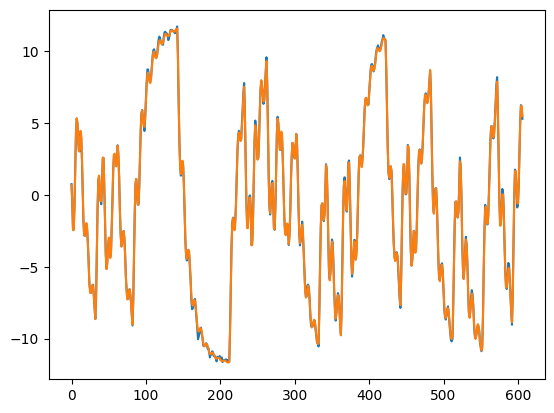

In [7]:
lr = LinearRegression()
lr.fit(X_train_split, Y_train_split)
y_val_OLS = []
aux = np.zeros(n_final)
y_prev = list(Y_train_split[-n_final:][::-1])
for k in range(test_size):
    u_lags = X_val_split[k, n_final:] 
    combined_input = y_prev + list(u_lags)[:m_final + 1]
    y_pred = lr.predict([combined_input])
    y_val_OLS.append(y_pred[0])
    aux[:] = y_prev[:]
    y_prev[0] = y_pred[0]
    for i in range(1, n_final):
        y_prev[i] = aux[i-1]
print(r2_score(Y_val_split, y_val_OLS))
print(mean_squared_error(Y_val_split, y_val_OLS))
plt.plot(Y_val_split, label='True')
plt.plot(y_val_OLS, label='OLS')

      alpha       mse  r2_score
0   0.00001  0.018364  0.999539
1   0.00102  0.018364  0.999539
2   0.00203  0.018364  0.999539
3   0.00304  0.018364  0.999539
4   0.00405  0.018364  0.999539
..      ...       ...       ...
95  0.09596  0.018369  0.999539
96  0.09697  0.018369  0.999539
97  0.09798  0.018369  0.999539
98  0.09899  0.018369  0.999539
99  0.10000  0.018369  0.999539

[100 rows x 3 columns]


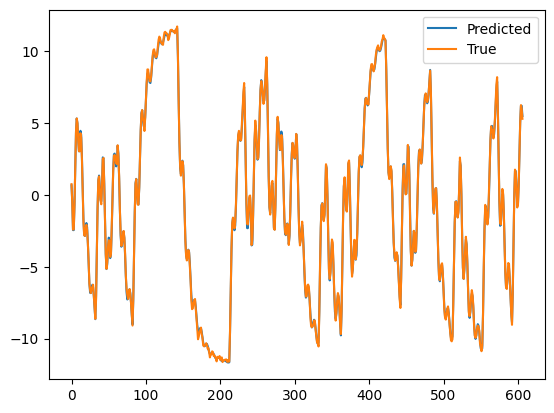

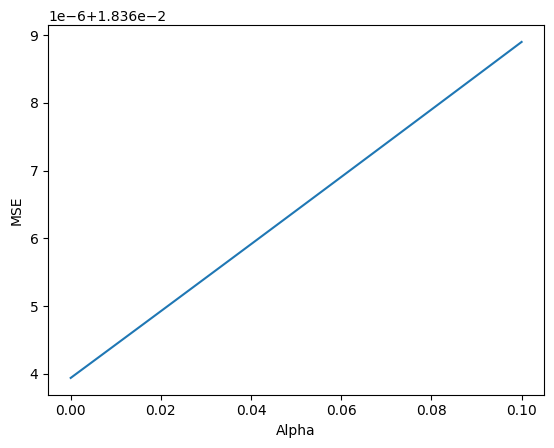

In [8]:
results = [] 

for alpha in alpha_values:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_split, Y_train_split)
        y_val_ridge = []
        aux = np.zeros(n_final)
        y_prev = list(Y_train_split[-n_final:][::-1])  # Initialize with last n values from the training set
        for k in range(test_size):
                u_lags = X_val_split[k, n_final:] 
                combined_input = y_prev + list(u_lags)[:m_final + 1]
                y_pred = ridge.predict([combined_input])
                y_val_ridge.append(y_pred[0])
                aux[:] = y_prev[:]
                y_prev[0] = y_pred[0]
                for i in range(1, n_final):
                        y_prev[i] = aux[i-1]
        score = r2_score(Y_val_split, y_val_ridge)
        mse = mean_squared_error(Y_val_split, y_val_ridge)
        results.append({'alpha': alpha, 'mse': mse, 'r2_score': score})

results_df = pd.DataFrame(results)

print(results_df.sort_values('mse'))
plt.plot(y_val_ridge, label='Predicted')
plt.plot(Y_val_split, label='True')
plt.legend()
plt.show()
plt.plot(results_df['alpha'], results_df['mse'])
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.131e+01, tolerance: 6.268e+00
  model = cd_fast.enet_coordinate_descent(


      alpha       mse  r2_score
0   0.00001  0.018350  0.999540
1   0.00102  0.018526  0.999535
2   0.00203  0.018967  0.999524
3   0.00304  0.019612  0.999508
4   0.00405  0.020753  0.999479
..      ...       ...       ...
95  0.09596  0.190375  0.995224
96  0.09697  0.192662  0.995167
97  0.09798  0.194979  0.995109
98  0.09899  0.197288  0.995051
99  0.10000  0.199587  0.994993

[100 rows x 3 columns]


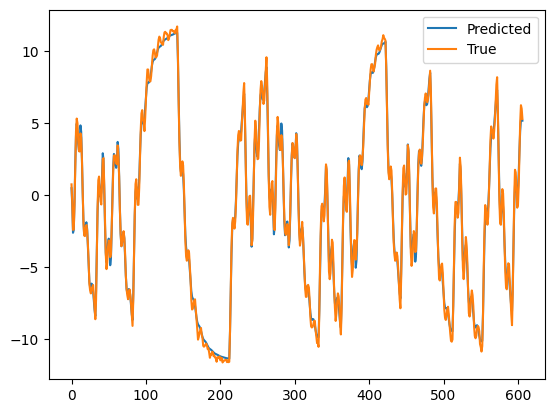

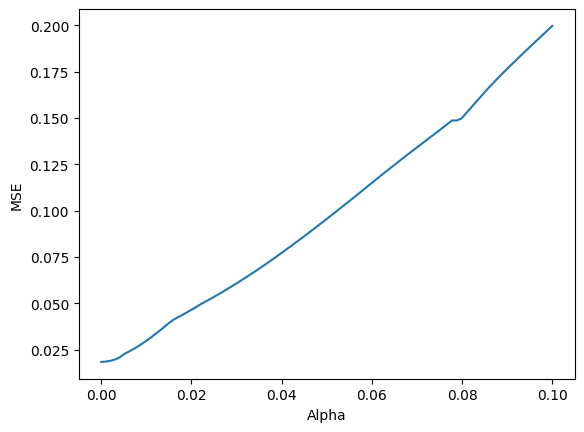

In [11]:
results = [] 

for alpha in alpha_values:
        lasso = Lasso(alpha=alpha,max_iter=100000)
        lasso.fit(X_train_split, Y_train_split)
        y_val_lasso = []
        aux = np.zeros(n_final)
        y_prev = list(Y_train_split[-n_final:][::-1])  # Initialize with last n values from the training set
        for k in range(test_size):
                u_lags = X_val_split[k, n_final:] 
                combined_input = y_prev + list(u_lags)[:m_final + 1]
                y_pred = lasso.predict([combined_input])
                y_val_lasso.append(y_pred[0])
                aux[:] = y_prev[:]
                y_prev[0] = y_pred[0]
                for i in range(1, n_final):
                        y_prev[i] = aux[i-1]
        score = r2_score(Y_val_split, y_val_lasso)
        mse = mean_squared_error(Y_val_split, y_val_lasso)
        results.append({'alpha': alpha, 'mse': mse, 'r2_score': score})

results_df = pd.DataFrame(results)

print(results_df.sort_values('mse'))
plt.plot(y_val_lasso, label='Predicted')
plt.plot(Y_val_split, label='True')
plt.legend()
plt.show()
plt.plot(results_df['alpha'], results_df['mse'])
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

In [61]:
results = [] 

for l1 in l1_ratios:
        for alpha in alpha_values:
                en = ElasticNet(alpha=alpha,max_iter=1000000)
                en.fit(X_train_split, Y_train_split)
                y_val_en = []
                aux = np.zeros(n_final)
                y_prev = list(Y_train_split[-n_final:][::-1])  # Initialize with last n values from the training set
                for k in range(test_size):
                        u_lags = X_val_split[k, n_final:] 
                        combined_input = y_prev + list(u_lags)[:m_final + 1]
                        y_pred = en.predict([combined_input])
                        y_val_en.append(y_pred[0])
                        aux[:] = y_prev[:]
                        y_prev[0] = y_pred[0]
                        for i in range(1, n_final):
                                y_prev[i] = aux[i-1]
                score = r2_score(Y_val_split, y_val_en)
                mse = mean_squared_error(Y_val_split, y_val_en)
                results.append({'l1': l1,'alpha': alpha, 'mse': mse, 'r2_score': score})

results_df = pd.DataFrame(results)

print(results_df)
plt.plot(y_val_en, label='Predicted')
plt.plot(Y_val_split, label='True')
plt.legend()
plt.show()
results_df = results_df.sort_values(by='mse')
print(results_df.head())

/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+01, tolerance: 6.268e+00
  model = cd_fast.enet_coordinate_descent(
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+01, tolerance: 6.268e+00
  model = cd_fast.enet_coordinate_descent(
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

KeyboardInterrupt: 

In [58]:
tscv = TimeSeriesSplit(n_splits=5)


alpha_values = np.linspace(1e-5,0.1,100)
l1_ratios = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] 

# Dictionary to store the models
models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet()
}

# To store the best R² score for each model
r2_scores = {model_name: [] for model_name in models.keys()}

tscv = TimeSeriesSplit(n_splits=5) 

r2_scores = {
    "OLS": [],
    "Ridge": [],
    "Lasso": [],
    "ElasticNet": []
}

for train_index, val_index in tscv.split(X_train):
    X_train_split, X_val_split = X_train[train_index], X_train[val_index]
    Y_train_split, Y_val_split = Y_train[train_index], Y_train[val_index]

    # Train and evaluate each model
    for model_name, model in models.items():
    
        if model_name == "Ridge":
            # Ridge Regression: Test different alpha values
            best_ridge_score = -np.inf
            for alpha in alpha_values:
                ridge = Ridge(alpha=alpha, fit_intercept=True)
                ridge.fit(X_train_split, Y_train_split)
                y_prev_ridge = list(Y_train_split[-n_final:][::-1])
                y_pred_val_ridge = []
                for k in range(len(Y_val_split)):
                    u_lags = X_val_split[k, n_final:]  
                    combined_input_ridge = y_prev_ridge + list(u_lags)[:m_final + 1]
                    y_pred = ridge.predict([combined_input_ridge])
                    y_pred_val_ridge.append(y_pred[0])
                    y_prev_ridge = [y_pred[0]] + y_prev_ridge[:-1]
                
                r2 = r2_score(Y_val_split, y_pred_val_ridge)
                mse = mean_squared_error(Y_val_split, y_pred_val_ridge)
                
                if r2 > best_ridge_score:
                    best_ridge_score = r2
                    best_alpha_ridge = alpha
                    best_mse_ridge = mse
            r2_scores["Ridge"].append(best_ridge_score)
        
        elif model_name == "Lasso":
            best_lasso_score = -np.inf
            for alpha in alpha_values:
                lasso = Lasso(alpha=alpha, fit_intercept=True,max_iter=1000000)
                lasso.fit(X_train_split, Y_train_split)
                y_prev_lasso = list(Y_train_split[-n_final:][::-1])
                y_pred_val_lasso = []
                for k in range(len(Y_val_split)):
                    u_lags = X_val_split[k, n_final:]  
                    combined_input_lasso = y_prev_lasso + list(u_lags)[:m_final + 1]
                    y_pred = lasso.predict([combined_input_lasso])
                    y_pred_val_lasso.append(y_pred[0])
                    y_prev_lasso = [y_pred[0]] + y_prev_lasso[:-1]
                
                r2 = r2_score(Y_val_split, y_pred_val_lasso)
                mse = mean_squared_error(Y_val_split, y_pred_val_lasso)
                
                if r2 > best_lasso_score:
                    best_lasso_score = r2
                    best_alpha_lasso = alpha
                    best_mse_lasso = mse

            # Store the best R² score for Ridge
            r2_scores["Lasso"].append(best_lasso_score)
            
        elif model_name == "ElasticNet":
            best_elastic_net_score = -np.inf
            for alpha in alpha_values:
                for l1_ratio in l1_ratios:
                    y_prev_enet = list(Y_train_split[-n_final:][::-1])
                    enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, max_iter=100000)
                    enet.fit(X_train_split, Y_train_split)
                    y_pred_val_enet = []
                    for k in range(len(Y_val_split)):
                        u_lags = X_val_split[k, n_final:]
                        combined_input = y_prev_enet + list(u_lags)[:m_final+1]
                        y_pred = enet.predict([combined_input])
                        y_pred_val_enet.append(y_pred[0])
                        y_prev_enet = [y_pred[0]] + y_prev_enet[:-1]
                    r2 = r2_score(Y_val_split, y_pred_val_enet)
                    if r2 > best_elastic_net_score:
                        best_elastic_net_score = r2
                        best_alpha_elastic_net = alpha
                        best_ratio_en = l1_ratio
            r2_scores["ElasticNet"].append(best_elastic_net_score)
            
        elif model_name == "OLS":
            
            lr = LinearRegression()
            lr.fit(X_train_split, Y_train_split)
            y_prev_OLS = list(Y_train_split[-n_final:][::-1])
            y_pred_val_OLS = []
            for k in range(len(Y_val_split)):
                u_lags = X_val_split[k, n_final:]
                combined_input = y_prev_OLS + list(u_lags)[:m_final+1]
                y_pred = lr.predict([combined_input])
                y_pred_val_OLS.append(y_pred[0])
                y_prev_OLS = [y_pred[0]] + y_prev_OLS[:-1]
            r2 = r2_score(Y_val_split, y_pred_val_OLS)
            r2_scores["OLS"].append(r2)
            mse_ols = mean_squared_error(Y_val_split,y_pred_val_OLS)
            
print(f"OLS R2: {r2_scores['OLS']} and MSE: {mse_ols}")           
print(f"Best Ridge alpha: {best_alpha_ridge}, with R² score: {best_ridge_score} and MSE: {best_mse_ridge}")
print(f"Best Lasso alpha: {best_alpha_lasso}, with R2 score: {best_lasso_score} and MSE: {best_mse_lasso} ")
print(f"Best ElasticNet alpha and l_1 ratio: {best_alpha_elastic_net} and {best_ratio_en}, with R2 score: {best_lasso_score} and MSE: {best_mse_lasso} ")
plt.plot(Y_val_split, label='True')
plt.plot(y_pred_val_lasso, label='Predicted')

[-3.99329976]
[-5.8899745]
[-7.59881915]
[-8.26806191]
[-8.00860953]
[-7.16463352]
[-6.56055557]
[-6.59298139]
[-7.40169452]
[-8.54379395]
[-9.53730765]
[-9.94539251]
[-9.769534]
[-9.26280568]
[-8.87433495]
[-8.88423198]
[-9.34685804]
[-10.02518202]
[-10.6100432]
[-10.85454735]
[-10.74147324]
[-10.43383652]
[-10.18961238]
[-10.18696947]
[-10.4537942]
[-10.85534025]
[-11.20122698]
[-11.34669877]
[-11.27597371]
[-11.08845765]
[-10.93633695]
[-8.87192126]
[-6.02132404]
[-3.40238561]
[-1.84947717]
[-1.49482198]
[-1.93737957]
[-2.20865206]
[-1.74641501]
[-0.37781122]
[1.52401004]
[3.21799343]
[4.2006978]
[4.40213043]
[4.11672858]
[3.88319073]
[4.13020615]
[4.92198861]
[6.01377549]
[7.01084207]
[7.58599586]
[7.67873518]
[7.49008943]
[7.33032076]
[7.4494249]
[7.90369659]
[8.5422001]
[9.12339474]
[9.45806899]
[9.50443603]
[9.37826336]
[9.2698053]
[9.32826987]
[9.58724056]
[9.9600343]
[10.30117326]
[10.49533378]
[10.51753008]
[10.43568972]
[10.36303846]
[10.39039915]
[8.48126928]
[5.69390902]
[

KeyboardInterrupt: 

In [105]:
u_combined = np.concatenate((u_train, u_test), axis=0)
best_model = Ridge(alpha=1e-5,fit_intercept=True)
best_model.fit(X_train,Y_train)
y_prev_final_model = list(Y_train[-n_final:][::-1]) #careful: it should be Y_train, since we are using all the data set.
y_pred_final_model = []
index_first_y_test = 2040
for k in range(index_first_y_test,len(u_combined)):
    u_val = [u_combined[k - d_final - j] for j in range(m_final + 1)]
    combined_input_final = y_prev_final_model + list(u_val)
    y_pred = best_model.predict([combined_input_final])
    y_pred_final_model.append(y_pred[0])
    y_prev_final_model = [y_pred[0]] + y_prev_final_model[:-1]
y_pred_last_400 = y_pred_final_model[-400:]
np.save('y_pred.npy', y_pred_last_400)